In [48]:
#This notebook is where we will test our code. We may convert all code to a .py file if necessary
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# global variables
BOARD_ROWS = 100
BOARD_COLS = 100
WIN_STATE = (3, 3)
LOSE_STATE = (1, 3)
LOSE_STATE_B = (4,1)
START = (0, 0)
DETERMINISTIC = True

In [45]:

class State:
    def __init__(self, state=START):
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.board[1, 1] = -1
        self.state = state
        self.isEnd = False
        self.determine = DETERMINISTIC

    def giveReward(self):
        if self.state == WIN_STATE:
            return 50
        elif self.state == LOSE_STATE:
            return -50
        elif self.state == LOSE_STATE_B:
            return -50
        else:
            return -1

    def isEndFunc(self):
        if (self.state == WIN_STATE) or (self.state == LOSE_STATE) or (self.state == LOSE_STATE_B):
            self.isEnd = True

    def nxtPosition(self, action):
        if self.determine:
            if action == "up":
                nxtState = (self.state[0] - 1, self.state[1])
            elif action == "down":
                nxtState = (self.state[0] + 1, self.state[1])
            elif action == "left":
                nxtState = (self.state[0], self.state[1] - 1)
            else:
                nxtState = (self.state[0], self.state[1] + 1)
            # if next state legal
            if (nxtState[0] >= 0) and (nxtState[0] <= (BOARD_ROWS -1)):
                if (nxtState[1] >= 0) and (nxtState[1] <= (BOARD_COLS -1)):
                    if nxtState != (1, 1):
                        return nxtState
            return self.state

    def showBoard(self):
        self.board[self.state] = 1
        for i in range(0, BOARD_ROWS):
            print('-----------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = '*'
                if self.board[i, j] == -1:
                    token = 'z'
                if self.board[i, j] == 0:
                    token = '0'
                out += token + ' | '
            print(out)
        print('-----------------')

In [46]:
# Agent of player
class Agent:

    def __init__(self):
        self.states = []
        self.actions = ["up", "down", "left", "right"]
        self.State = State()
        self.lr = 0.2
        self.exp_rate = 0.3
        self.prob=0.25
        self.disc_fact=0.9

        # initial state reward
        self.state_values = {}
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.state_values[(i, j)] = 0  # set initial value to 0

    def chooseAction(self):
        # choose action with most expected value
        mx_nxt_reward = 0
        action = ""

        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
        else:
            # greedy action
            for a in self.actions:
                # if the action is deterministic
                nxt_reward = self.state_values[self.State.nxtPosition(a)]
                if nxt_reward >= mx_nxt_reward:
                    action = a
                    mx_nxt_reward = nxt_reward
        return action

    def takeAction(self, action):
        position = self.State.nxtPosition(action)
        return State(state=position)

    def reset(self):
        self.states = []
        self.State = State()

    def play(self, rounds=10, theta=0.001):
        i = 0
        steps = 0
        cum_reward = 0
        self.step_reward_df = pd.DataFrame( columns=['Round','Steps','Reward'])
        while i < rounds:
            # to the end of game back propagate reward
            if self.State.isEnd:
                # back propagate
                reward = self.State.giveReward()
                cum_reward = cum_reward + self.State.giveReward()
                # explicitly assign end state to reward values
                self.state_values[self.State.state] = reward  # this is optional
                #print(cum_reward)
                self.step_reward_df.loc[len(self.step_reward_df.index)] = [i, steps, cum_reward] 
                #self.step_reward_df.append(df)
                #print("Game End Reward", reward)
                for s in reversed(self.states):
                    reward = self.prob * (reward + (self.disc_fact * self.state_values[s]))
                    self.state_values[s] = round(reward, 3)
                self.reset()
                i += 1
                steps = 0
                cum_reward = 0
            else:
                steps += 1
                cum_reward = cum_reward + self.State.giveReward()
                action = self.chooseAction()
                # append trace
                self.states.append(self.State.nxtPosition(action))
                #print("current position {} action {}".format(self.State.state, action))
                # by taking the action, it reaches the next state
                self.State = self.takeAction(action)
                # mark is end
                self.State.isEndFunc()
                
                #print(cum_reward)
                #print("nxt state", self.State.state)
                #print("---------------------")

    def showValues(self):
        for i in range(0, BOARD_ROWS):
            print('----------------------------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                out += str(self.state_values[(i, j)]).ljust(6) + ' | '
            print(out)
        print('----------------------------------')

In [49]:
#Baseline Test Disc: 0.9, Exp: 0.3, prob: 0.25
if __name__ == "__main__":
    ag = Agent()
    ag.play(100)
    #print(ag.showValues())
    values= ag.state_values
    step_reward_df = ag.step_reward_df
df = pd.DataFrame.from_dict(values, orient='index')
df[['row','column']] = df.index.values.tolist()
df = df.set_index(['row','column'])[0].unstack()
#display(step_reward_df)
# Heatmap
fig, ax = plt.subplots(figsize=(13,7))
title = "Value Iteration Heat Map"
plt.title(title,fontsize=18)
ttl = ax.title
ttl.set_position([0.5,1.05])
sns.heatmap(df,annot = df,fmt="",cmap='RdYlGn',linewidths=0.30)
plt.show()
#reward and steps per iteration
sns.lineplot(data=step_reward_df, x="Round", y="Steps")
plt.show() 

sns.lineplot(data=step_reward_df, x="Round", y="Reward")
plt.show() 


KeyboardInterrupt



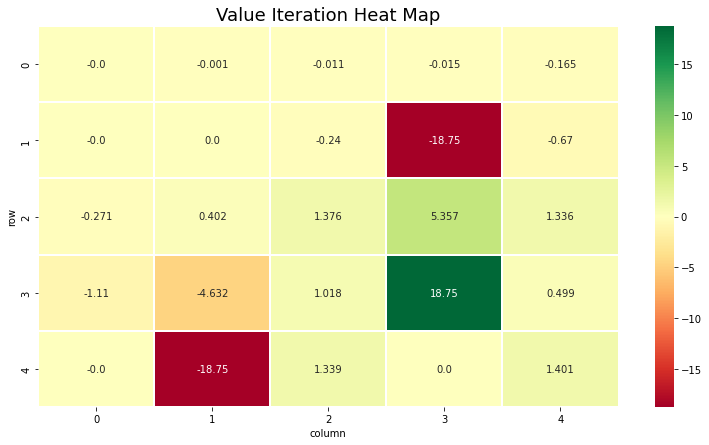

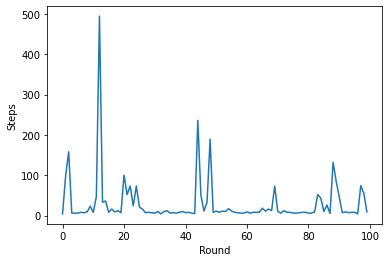

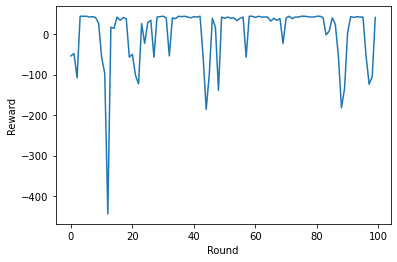

In [42]:
#Experiment Simplified Code 
class Agent:
    def __init__(self):
        self.states = []
        self.actions = ["up", "down", "left", "right"]
        self.State = State()
        self.lr = 0.2
        self.exp_rate = 0.25
        self.prob=0.25
        self.disc_fact=0.5
        self.state_values = {}
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.state_values[(i, j)] = 0
    def chooseAction(self):
        mx_nxt_reward = 0
        action = ""
        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
        else:
            for a in self.actions:
                nxt_reward = self.state_values[self.State.nxtPosition(a)]
                if nxt_reward >= mx_nxt_reward:
                    action = a
                    mx_nxt_reward = nxt_reward
        return action
    def takeAction(self, action):
        position = self.State.nxtPosition(action)
        return State(state=position)
    def reset(self):
        self.states = []
        self.State = State()
    def play(self, rounds=10, theta=0.001):
        i = 0
        steps = 0
        cum_reward = 0
        self.step_reward_df = pd.DataFrame( columns=['Round','Steps','Reward'])
        while i < rounds:
            if self.State.isEnd:
                reward = self.State.giveReward()
                cum_reward = cum_reward + self.State.giveReward()
                self.state_values[self.State.state] = reward
                self.step_reward_df.loc[len(self.step_reward_df.index)] = [i, steps, cum_reward]
                for s in reversed(self.states):
                    reward = self.prob * (reward + (self.disc_fact * self.state_values[s]))
                    self.state_values[s] = round(reward, 3)
                self.reset()
                i += 1
                steps = 0
                cum_reward = 0
            else:
                steps += 1
                cum_reward = cum_reward + self.State.giveReward()
                action = self.chooseAction()
                self.states.append(self.State.nxtPosition(action))
                self.State = self.takeAction(action)
                self.State.isEndFunc()
    def showValues(self):
        for i in range(0, BOARD_ROWS):
            print('----------------------------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                out += str(self.state_values[(i, j)]).ljust(6) + ' | '
            print(out)
        print('----------------------------------')
if __name__ == "__main__":
    ag = Agent()
    ag.play(100)
    #print(ag.showValues())
    values= ag.state_values
    step_reward_df = ag.step_reward_df
df = pd.DataFrame.from_dict(values, orient='index')
df[['row','column']] = df.index.values.tolist()
df = df.set_index(['row','column'])[0].unstack()
# Heatmap
fig, ax = plt.subplots(figsize=(13,7))
title = "Value Iteration Heat Map"
plt.title(title,fontsize=18)
ttl = ax.title
ttl.set_position([0.5,1.05])
sns.heatmap(df,annot = df,fmt="",cmap='RdYlGn',linewidths=0.30)
plt.show()
#reward and steps per iteration
sns.lineplot(data=step_reward_df, x="Round", y="Steps")
plt.show() 

sns.lineplot(data=step_reward_df, x="Round", y="Reward")
plt.show() 

In [55]:
#A* Algorithm
import numpy as np

BOARD_ROWS = 100
BOARD_COLS = 100
WIN_STATE = (3, 3)
LOSE_STATE = (1, 1)
LOSE_STATE_B = (4,1)
START = (0, 0)
DETERMINISTIC = True

class Node():
    """A node class for A* Pathfinding"""

    def __init__(self, parent=None, position=None):
        self.parent = parent
        self.position = position

        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        return self.position == other.position


def astar(board, start, end, lose, loseB):
    """Returns a list of tuples as a path from the given start to the given end in the given board"""

    # Create start and end node
    start_node = Node(None, start)
    start_node.g = start_node.h = start_node.f = 0
    end_node = Node(None, end)
    end_node.g = end_node.h = end_node.f = 0
    lose_state_node = Node(None, lose)
    lose_state_node.g = lose_state_node.h = lose_state_node.f = 0
    lose_stateb_node = Node(None, loseB)
    lose_stateb_node.g = lose_stateb_node.h = lose_stateb_node.f = 0
    
    # Initialize both open and closed list
    open_list = []
    closed_list = []

    # Add the start node
    open_list.append(start_node)

    # Loop until you find the end
    while len(open_list) > 0:

        # Get the current node
        current_node = open_list[0]
        current_index = 0
        for index, item in enumerate(open_list):
            if item.f < current_node.f:
                current_node = item
                current_index = index

        # Pop current off open list, add to closed list
        open_list.pop(current_index)
        closed_list.append(current_node)

        # Found the goal
        if current_node == end_node:
            path = []
            current = current_node
            while current is not None:
                path.append(current.position)
                current = current.parent
            return path[::-1] # Return reversed path

        # Generate children
        children = []
        for new_position in [(0, -1), (0, 1), (-1, 0), (1, 0)]: # Adjacent squares

            # Get node position
            node_position = (current_node.position[0] + new_position[0], current_node.position[1] + new_position[1])

            # Make sure within range
            if node_position[0] > (len(board) - 1) or node_position[0] < 0 or node_position[1] > (len(board[len(board)-1]) -1) or node_position[1] < 0:
                continue

            # Make sure walkable terrain
            if board[node_position[0]][node_position[1]] != 0:
                continue
            # Create new node
            new_node = Node(current_node, node_position)

            # Append
            children.append(new_node)

        # Loop through children
        for child in children:

            # Child is on the closed list
            for closed_child in closed_list:
                if child == closed_child:
                    continue

            # Create the f, g, and h values
            child.g = current_node.g + 1
            child.h = ((child.position[0] - end_node.position[0]) ** 2) + ((child.position[1] - end_node.position[1]) ** 2)
            child.f = child.g + child.h

            # Child is already in the open list
            for open_node in open_list:
                if child == open_node and child.g > open_node.g:
                    continue

            # Add the child to the open list
            open_list.append(child)


def main():
    def __init__(self, state=START):
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.board[1, 1] = -1
        self.state = state
        self.isEnd = False
    def showBoard(self):
        self.board[self.state] = 1
        for i in range(0, BOARD_ROWS):
            print('-----------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = '*'
                if self.board[i, j] == -1:
                    token = 'z'
                if self.board[i, j] == 0:
                    token = '0'
                out += token + ' | '
            print(out)
        print('-----------------')

    def showValues(self):
        for i in range(0, BOARD_ROWS):
            print('----------------------------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                out += str(self.state_values[(i, j)]).ljust(6) + ' | '
            print(out)
        print('----------------------------------')
    start = START
    end = WIN_STATE
    lose=LOSE_STATE
    loseB=LOSE_STATE_B
    #board = np.zeros([BOARD_ROWS, BOARD_COLS])
    arr = np.zeros([BOARD_ROWS, BOARD_COLS])
    arr[1][1] = 1
    arr[4][1] = 1
    board=arr
    path = astar(board, start, end ,lose, loseB)
    print(path)
    return path


if __name__ == '__main__':
    mn=main()

[(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3), (3, 3)]


In [58]:
print(mn)
x_coords = []
y_coords = []
for i in (range(0,len(mn))):
    x = mn[i][0]
    y = mn[i][1]
    x_coords.append(x)
    y_coords.append(y)

[(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3), (3, 3)]


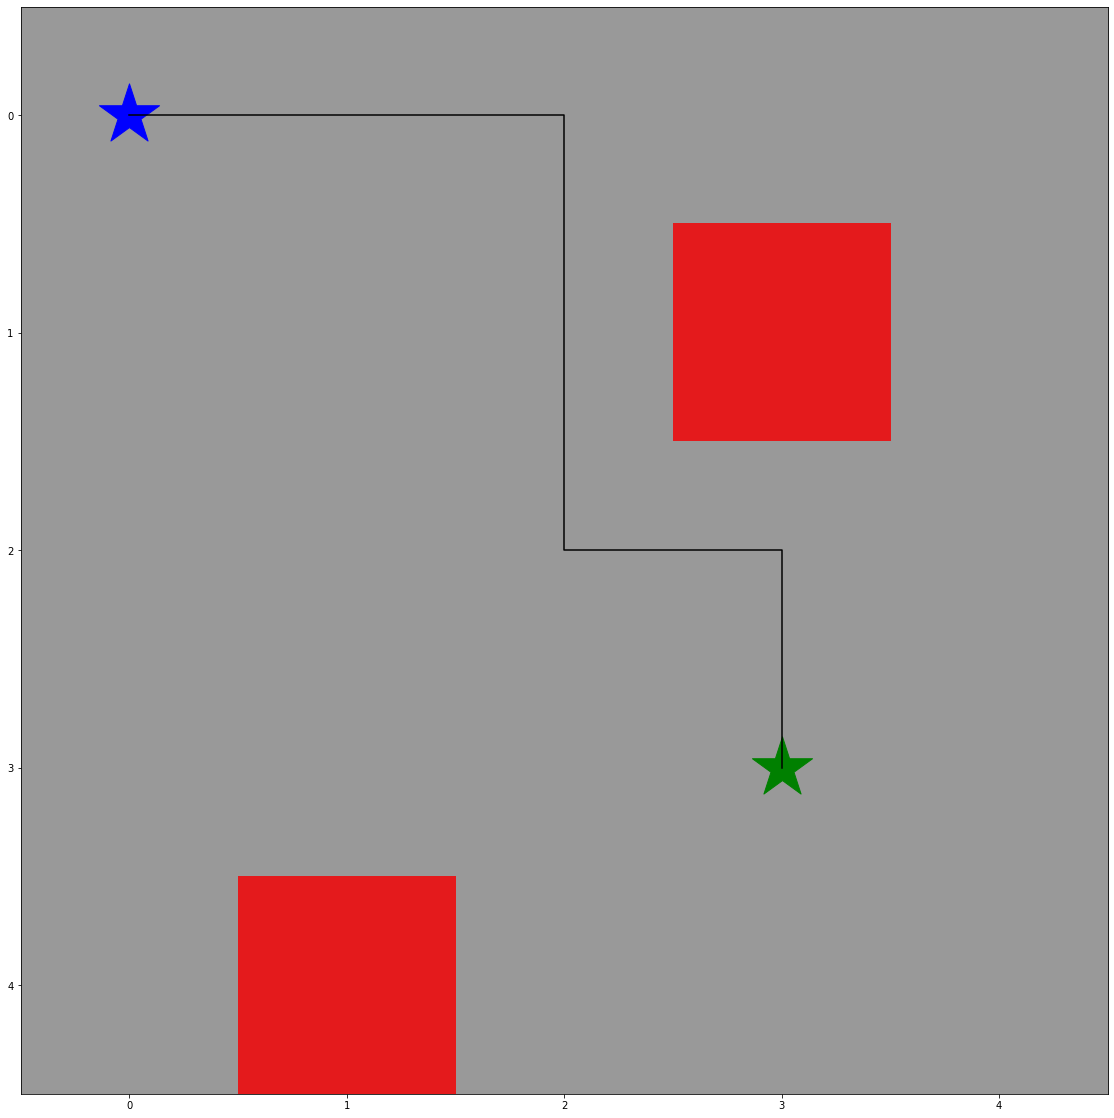

In [70]:
grid = np.array([
    [1, 1, 1, 1, 1],
    [1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 0, 1, 1, 1]])
start = (0,0)
goal = (3,3)

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(grid, cmap=plt.cm.Set1)
ax.scatter(start[1],start[0], marker = "*", color = "blue", s = 4000)
ax.scatter(goal[1],goal[0], marker = "*", color = "green", s = 4000)
ax.plot(y_coords,x_coords, color = "black")
plt.show()